# Coexpresion analysis for HBEC IFN experiment

In [5]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from pybedtools import BedTool
import pickle as pkl
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/data/home/anaconda3/envs/single_cell/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [6]:
import sys
sys.path.append('/data/home/Github/scrna-parameter-estimation/dist/memento-0.0.4-py3.7.egg')
sys.path.append('/data/home/Github/misc-seq/miscseq/')
import encode
import memento

In [7]:
data_path = '/data_volume/ifn_hbec/'

### Read and select TFs

In [8]:
tf_df = pd.read_csv('DatabaseExtract_v_1.01.csv', index_col=0)
tf_df = tf_df[tf_df['TF assessment'] == 'Known motif']
tfs = tf_df['HGNC symbol'].tolist()

In [9]:
condensed_tfs = []
for tf in tfs:
    if 'STAT' in tf:
        condensed_tfs.append(tf)
    elif 'IRF' in tf:
        condensed_tfs.append(tf)
    elif 'NFKB' in tf:
        condensed_tfs.append(tf)
    elif 'JUN' in tf:
        condensed_tfs.append(tf)
    elif 'MYC' in tf:
        condensed_tfs.append(tf)
    elif 'FOS' in tf:
        condensed_tfs.append(tf)
    else:
        continue

### Read 2d HT result comparing to control

In [10]:
cts = [['ciliated'], ['bc', 'club'], ['basal']]
tps = ['3', '6', '9', '24', '48']
stims = ['alpha', 'beta', 'gamma', 'lambda']

In [12]:
def read_result(tf, ct):
    
    ht_dict = {}
    moments_dict = {}
    
    for stim in stims:
        ht_dict[stim] = {}
        moments_dict[stim] = {}
        for tp in tps:
            try:
                adata = sc.read('/data_volume/ifn_hbec/coex_test/{}_{}_{}_{}.h5ad'.format('-'.join(ct), stim, tp, tf))
            except:
                continue
            ht_dict[stim][tp] = memento.get_2d_ht_result(adata)
            ht_dict[stim][tp]['corr_fdr'] = memento.util._fdrcorrect(ht_dict[stim][tp]['corr_pval'])
            moments_dict[stim][tp] = memento.get_2d_moments(adata, groupby='time_step')
    return ht_dict,moments_dict

In [ ]:
all_result = {}

for tf in condensed_tfs:
    all_result[tf] = {}
    for ct in cts:

        key = '-'.join(ct)
        all_result[tf][key] = {}
        all_result[tf][key]['ht'], all_result[tf][key]['moments'] = read_result(tf, ct)

### Number of DC genes over time

In [17]:
all_result['STAT1']['ciliated'].keys()

dict_keys(['adata'])

In [10]:
def plot_num_de_dv(ct, tf):
    
    dc_count = np.zeros((len(stims), len(tps)))
    
    for i, stim in enumerate(stims):
        for j, tp in enumerate(tps):
            
            if ct == 'all':
                
                combined_df = pd.concat([all_result[tf]['-'.join(c)]['ht'][stim][tp] for c in cts])
                dc_count[i, j] = combined_df.query('corr_fdr < 0.1'.format(tf)).gene_2.drop_duplicates().shape[0]
            else:
                df = all_result[tf][ct]['ht'][stim][tp]
                dc_count[i, j] = df.query('corr_fdr < 0.1').shape[0]
                
    dc_count = np.hstack([np.zeros((len(stims), 1)), dc_count])
    plt.figure(figsize=(5, 2));
    for i in range(len(stims)):
        plt.plot([0.0]+[float(int(tp)) for tp in tps], dc_count[i, :], '--o')
    plt.ylabel('DC count'); plt.legend(stims, loc='upper center', ncol=4, bbox_to_anchor=(1.3, 1.25), frameon=False); plt.xlabel('time')
    
plot_num_de_dv('bc-club', 'STAT1')
plot_num_de_dv('ciliated', 'STAT1')

KeyError: 'ht'

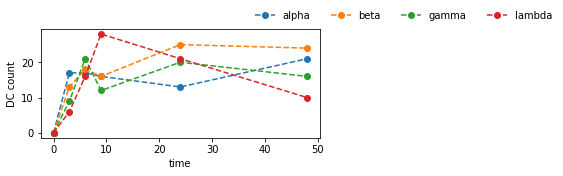

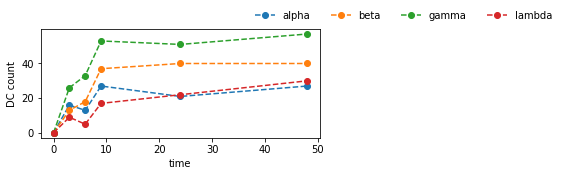

In [48]:
def plot_num_de_dv(ct, tf):
    
    dc_count = np.zeros((len(stims), len(tps)))
    
    for i, stim in enumerate(stims):
        for j, tp in enumerate(tps):
            
            if ct == 'all':
                
                df_list = []
                for c in cts:
                    df = all_result['-'.join(c)]['ht'][stim][tp].query('gene_1 == "{}"'.format(tf)).copy()
                    df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])
                    df_list.append(df)
                
                combined_df = pd.concat(df_list)
                dc_count[i, j] = combined_df.query('corr_pval < 0.1'.format(tf)).gene_2.drop_duplicates().shape[0]
            else:
                df = all_result[ct]['ht'][stim][tp].query('gene_1 == "{}"'.format(tf)).copy()
                df['corr_fdr'] = memento.util._fdrcorrect(df['corr_pval'])
                dc_count[i, j] = df.query('corr_pval < 0.1').shape[0]
                
    dc_count = np.hstack([np.zeros((len(stims), 1)), dc_count])
    plt.figure(figsize=(5, 2));
    for i in range(len(stims)):
        plt.plot([0.0]+[float(int(tp)) for tp in tps], dc_count[i, :], '--o')
    plt.ylabel('DC count'); plt.legend(stims, loc='upper center', ncol=4, bbox_to_anchor=(1.3, 1.25), frameon=False); plt.xlabel('time')
    
plot_num_de_dv('bc-club', 'STAT1')
plot_num_de_dv('ciliated', 'STAT1')

### Get HT result and moments

In [51]:
moment_df_list = []
ht_df_list = []

In [52]:
for ct in cts:
    
    key = key = '-'.join(ct)
    for stim in stims:
        for tp in tps:
            
            df = all_result[key]['ht'][stim][tp]
            df['stim'] = stim
            df['ct'] = key
            df['tp'] = int(tp)
            
            ht_df_list.append(df.copy())
ht_df = pd.concat(ht_df_list)

In [53]:
for ct in cts:
    
    key = key = '-'.join(ct)
    for stim in stims:
        for tp in tps:
            
            df_ctrl = pd.DataFrame()
            df_ctrl['gene'] = all_result[key]['moments'][stim][tp][0]['gene'].tolist()
            df_ctrl['mean'] = all_result[key]['moments'][stim][tp][0]['0'].tolist()
            df_ctrl['var'] = all_result[key]['moments'][stim][tp][1]['0'].tolist()
            df_ctrl['stim'] = 'ctrl'
            df_ctrl['ct'] = key
            df_ctrl['tp'] = 0
            
            df_stim = pd.DataFrame()
            df_stim['gene'] = all_result[key]['moments'][stim][tp][0]['gene'].tolist()
            df_stim['mean'] = all_result[key]['moments'][stim][tp][0]['1'].tolist()
            df_stim['var'] = all_result[key]['moments'][stim][tp][1]['1'].tolist()
            df_stim['stim'] = stim
            df_stim['ct'] = key
            df_stim['tp'] = int(tp)
            
            moment_df_list.append(df_ctrl)
            moment_df_list.append(df_stim)
moment_df = pd.concat(moment_df_list).drop_duplicates()

### Plot effect sizes

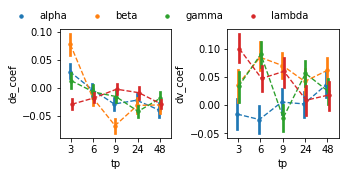

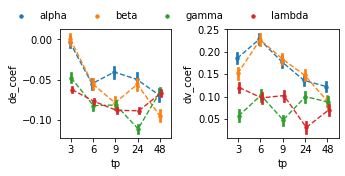

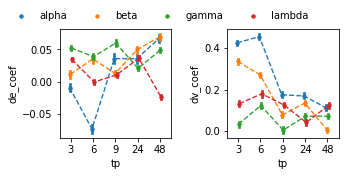

In [84]:
def plot_es(ct):
    plt.figure(figsize=(5, 2));
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    sns.pointplot(x='tp', y='de_coef', hue='stim', data=ht_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.5); plt.legend(loc='upper center', bbox_to_anchor=(0.9, 1.25), ncol=4, frameon=False)
    plt.subplot(1, 2, 2)
    sns.pointplot(x='tp', y='dv_coef', hue='stim', data=ht_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.5); plt.legend([], frameon=False)
plot_es('basal')
plot_es('bc-club')
plot_es('ciliated')

### Plot moments

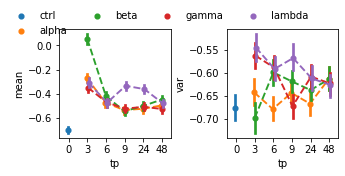

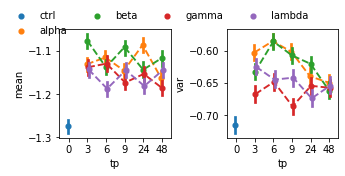

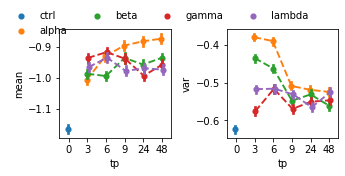

In [85]:
def plot_moments(ct):
    plt.figure(figsize=(5, 2));
    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    sns.pointplot(x='tp', y='mean', hue='stim', data=moment_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.7); plt.legend(loc='upper center', bbox_to_anchor=(0.9, 1.25), ncol=4, frameon=False)
    plt.subplot(1, 2, 2)
    sns.pointplot(x='tp', y='var', hue='stim', data=moment_df.query('ct == "{}"'.format(ct)), ci=66, dodge=True, linestyles='--', scale=.7); plt.legend([], frameon=False)
plot_moments('basal')
plot_moments('bc-club')
plot_moments('ciliated')